In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from ebmdatalab import charts

In [2]:
def q(sql):
    return pd.read_gbq(sql, dialect='standard', project_id='ebmdatalab')

In [3]:
numerators = q('''
SELECT
    practice,
    pct,
    CAST(month AS DATE) AS month,
    SUM(items) AS numerator
FROM hscic.normalised_prescribing_standard presc
INNER JOIN hscic.practices pract ON presc.practice = pract.code
WHERE 
    pract.setting = 4 AND
    presc.bnf_code IN (
        SELECT DISTINCT(bnf_code)
        FROM measures.vw__chapter_3_dmd_objs_with_form_route
        WHERE form_route = 'pressurizedinhalation.inhalation'
    )
GROUP BY practice, pct, month
ORDER BY practice, month
''').set_index(['practice', 'month'])

/Users/inglesp/.pyenv/versions/3.7.0/envs/ebmdatalab-jupyter-notebooks/lib/python3.7/site-packages/google/auth/_default.py:66: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [4]:
numerators.head()

pct  numerator
practice month                     
A81001   2010-08-01  00K        210
         2010-09-01  00K        247
         2010-10-01  00K        255
         2010-11-01  00K        233
         2010-12-01  00K        285

In [5]:
denominators = q('''
SELECT
    practice,
    pct,
    CAST(month AS DATE) AS month,
    SUM(items) AS denominator
FROM hscic.normalised_prescribing_standard presc
INNER JOIN hscic.practices pract ON presc.practice = pract.code
WHERE 
    pract.setting = 4 AND
    presc.bnf_code IN (
        SELECT DISTINCT(bnf_code)
        FROM measures.vw__chapter_3_dmd_objs_with_form_route
        WHERE form_route IN ('pressurizedinhalation.inhalation', 'powderinhalation.inhalation')
    )
GROUP BY practice, pct, month
ORDER BY practice, month
''').set_index(['practice', 'month'])

In [6]:
denominators.head()

pct  denominator
practice month                       
A81001   2010-08-01  00K          289
         2010-09-01  00K          355
         2010-10-01  00K          344
         2010-11-01  00K          358
         2010-12-01  00K          382

In [7]:
data = {
    'pct': numerators['pct'],
    'numerator': numerators['numerator'],
    'denominator': denominators['denominator'],
}
practices = pd.DataFrame(index=numerators.index, data=data).reset_index()
practices['ratio'] = practices['numerator'] / practices['denominator']

In [8]:
practices.head()

,practice,month,pct,numerator,denominator,ratio
0,A81001,2010-08-01,00K,210,289,0.726644
1,A81001,2010-09-01,00K,247,355,0.695775
2,A81001,2010-10-01,00K,255,344,0.741279
3,A81001,2010-11-01,00K,233,358,0.650838
4,A81001,2010-12-01,00K,285,382,0.746073


In [9]:
ccgs = practices.groupby(['pct', 'month'])['numerator', 'denominator'].sum().reset_index()
ccgs['ratio'] = ccgs['numerator'] / ccgs['denominator']

In [10]:
ccgs.head()

,pct,month,numerator,denominator,ratio
0,00C,2010-08-01,4603,6559,0.701784
1,00C,2010-09-01,5039,7152,0.704558
2,00C,2010-10-01,4921,6907,0.712466
3,00C,2010-11-01,5086,7219,0.704530
4,00C,2010-12-01,5673,8094,0.700890


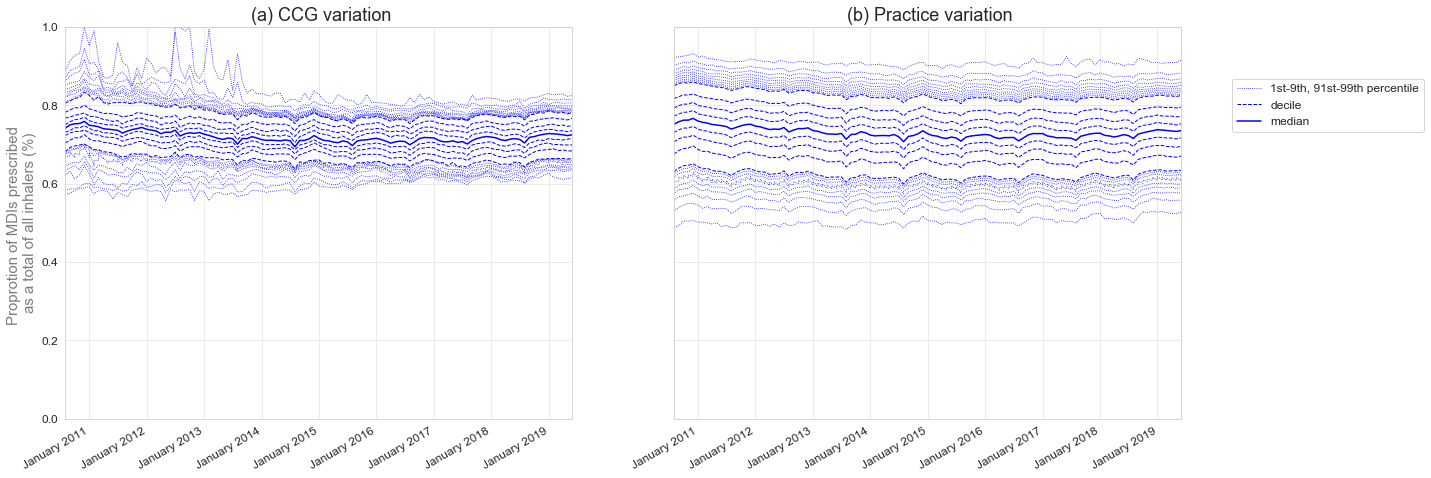

In [12]:
f = plt.figure(figsize=(20,8))
f.autofmt_xdate()
layout = gridspec.GridSpec(1, 2, figure=f)
left_plot = plt.subplot(layout[0])
right_plot = plt.subplot(layout[1], sharey=left_plot)  # Share the Y axis 

# ...and because it's shared, suppress ticks on the second chart
plt.setp(right_plot.get_yticklabels(), visible=False)

charts.deciles_chart(
    ccgs,
    period_column='month',
    column='ratio',
    title=" (a) CCG variation",
    ylabel="Proprotion of MDIs prescribed \n as a total of all inhalers (%) ",
    show_outer_percentiles=True,
    show_legend=False,
    ax=left_plot, 
) 

charts.deciles_chart(
    practices,
    period_column='month',
    column='ratio',
    title=" (b) Practice variation",
    ylabel="",
    show_outer_percentiles=True,
    show_legend=True,
    ax=right_plot,
) 

plt.ylim(0, 1)
plt.show()